# Show the NIRSpec wavecal spectra from CAL-1125

See https://dawn-cph.github.io/dja/spectroscopy/nirspec-wavecal/

*(G. Brammer, 20 July 2023)*

In [1]:
# %matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

import scipy.ndimage as nd

import astropy.io.fits as pyfits
import astropy.units as u
from astropy.table import Table

from grizli import utils

# Higher resolution
FIGURE_DPI = 180

In [2]:
base_url = 'https://dawn-cph.github.io/dja/data/nirspec-wavecal/'
files = Table.read(base_url + 'files.csv', format='csv')
files

file,filter,grating
str57,str6,str5
calib_g140h-f070lp_iras-05248-7007_s200a1.v1.spec.fits.gz,F070LP,G140H
calib_g140h-f100lp_iras-05248-7007_s200a1.v1.spec.fits.gz,F100LP,G140H
calib_g140m-f070lp_iras-05248-7007_s200a1.v1.spec.fits.gz,F070LP,G140M
calib_g140m-f100lp_iras-05248-7007_s200a1.v1.spec.fits.gz,F100LP,G140M
calib_g235h-f170lp_iras-05248-7007_s200a1.v1.spec.fits.gz,F170LP,G235H
calib_g235m-f170lp_iras-05248-7007_s200a1.v1.spec.fits.gz,F170LP,G235M
calib_g395h-f290lp_iras-05248-7007_s200a1.v1.spec.fits.gz,F290LP,G395H
calib_g395m-f290lp_iras-05248-7007_s200a1.v1.spec.fits.gz,F290LP,G395M
calib_prism-clear_iras-05248-7007_s200a1.v1.spec.fits.gz,CLEAR,PRISM


In [3]:
spec = {}
img = {}
for row in files:
    key = '{filter} {grating}'.format(**row)
    print(f"{key} {row['file']}")
    img[key] = pyfits.open(base_url + row['file'])
    spec[key] = Table.read(img[key]['SPEC1D'])
        

F070LP G140H calib_g140h-f070lp_iras-05248-7007_s200a1.v1.spec.fits.gz
F100LP G140H calib_g140h-f100lp_iras-05248-7007_s200a1.v1.spec.fits.gz
F070LP G140M calib_g140m-f070lp_iras-05248-7007_s200a1.v1.spec.fits.gz
F100LP G140M calib_g140m-f100lp_iras-05248-7007_s200a1.v1.spec.fits.gz
F170LP G235H calib_g235h-f170lp_iras-05248-7007_s200a1.v1.spec.fits.gz
F170LP G235M calib_g235m-f170lp_iras-05248-7007_s200a1.v1.spec.fits.gz
F290LP G395H calib_g395h-f290lp_iras-05248-7007_s200a1.v1.spec.fits.gz
F290LP G395M calib_g395m-f290lp_iras-05248-7007_s200a1.v1.spec.fits.gz
CLEAR PRISM calib_prism-clear_iras-05248-7007_s200a1.v1.spec.fits.gz


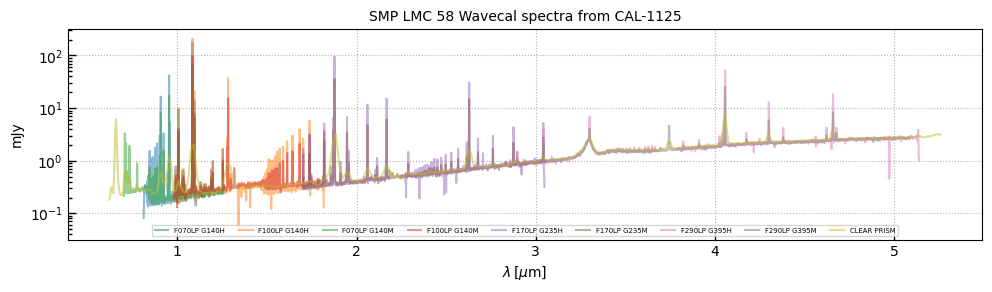

In [4]:
COLORS = {}

fig, ax = plt.subplots(1,1,figsize=(10,3))
for k in spec:
    # Mask missing data
    valid = nd.binary_erosion(spec[k]['flux'] > 0, iterations=4)
    mjy = spec[k]['flux'].to('mJy')
    mjy[~valid] = np.nan
    spec[k]['flux_mjy'] = mjy
    pl = ax.plot(spec[k]['wave'], mjy, label=k, alpha=0.5)
    COLORS[k] = pl[0].get_color()
    
ax.set_xlabel(r'$\lambda\,[\mu\mathrm{m}]$')
ax.set_ylabel('mJy')
ax.set_title('SMP LMC 58 Wavecal spectra from CAL-1125')
ax.semilogy()
ax.grid()
ax.legend(loc='lower center', ncol=9, fontsize=5)

fig.tight_layout(pad=1)
fig.tight_layout(pad=1)

fig.savefig(f'smp58_nirspec_full.png', dpi=FIGURE_DPI)

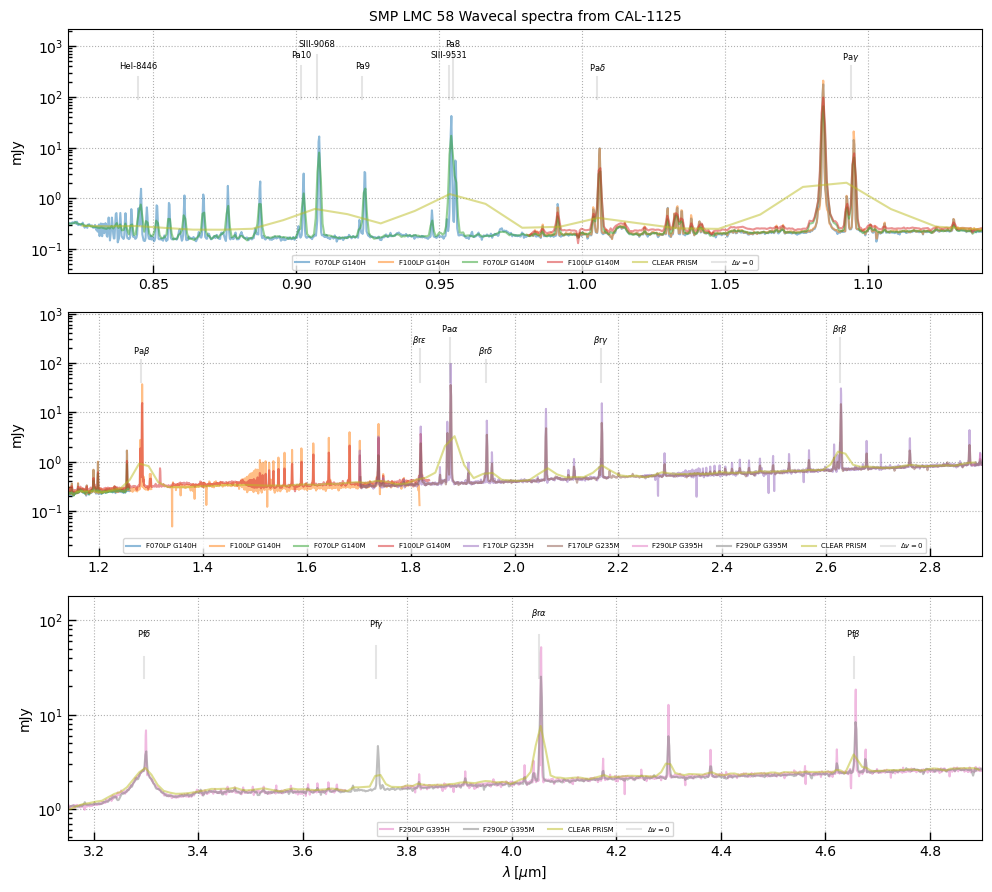

In [5]:
lw, lr = utils.get_line_wavelengths()

lims = [(0.82, 1.14), (1.14, 2.9), (3.15, 4.9)]

fig, axes = plt.subplots(len(lims),1,figsize=(10,3*len(lims)))

for ix, xlim in enumerate(lims):
    ax = axes[ix]
    
    for k in spec:
        masked_mjy = spec[k]['flux_mjy']*1
        masked_mjy[(spec[k]['wave'] < xlim[0]) | (spec[k]['wave'] > xlim[1])] = np.nan
        
        if np.isfinite(masked_mjy).sum() > 0:
            ax.plot(spec[k]['wave'], masked_mjy, label=k, alpha=0.5, color=COLORS[k])

    ax.set_xlim(xlim)

    # Line labels
    lgreek = lambda ln : ln.replace('A',r'$\alpha$').replace('B',r'$\beta$').replace('G',r'$\gamma$').replace('D',r'$\delta$').replace('E',r'$\epsilon$')

    lws, lns = [], []
    for l in lw:
        #if (l[:2] in ['Pa','Br','Pf']) | ('1083' in l):
        if (lw[l][0]/1.e4 > xlim[0]) & (lw[l][0]/1.e4 < xlim[1]) & (len(lw[l]) == 1):
            lws.append(lw[l][0]/1.e4)
            lns.append(l)

    jwrap = 3
    ax.semilogy()
    yr = np.array(ax.get_ylim())
    
    logr = np.diff(np.log10(yr))[0]
    wpad = 1.15**(logr)
    yr *= wpad**np.array([-2,4])
    
    ax.set_ylim(yr)
    
    yl = yr[1] / wpad**jwrap
    
    for j, i in enumerate(np.argsort(lws)):
        ax.text(lws[i], yl*wpad**(j % jwrap), lgreek(lns[i]), ha='center', va='top', fontsize=6)
        ax.plot(np.ones(2)*lws[i],
                [yl*0.5*wpad**-2, yl*0.5*wpad**(j % jwrap)],
                color='k', linestyle='-', alpha=0.1,
                label=(r'$\Delta v = 0$' if j == 0 else None),
               )
        
    ax.set_ylabel(r'mJy')
    ax.legend(loc='lower center', ncol=10, fontsize=5)
    ax.grid()
    
axes[0].set_title('SMP LMC 58 Wavecal spectra from CAL-1125')

ax.set_xlabel(r'$\lambda\,[\mu\mathrm{m}]$')

fig.tight_layout(pad=1)
fig.tight_layout(pad=1)

fig.savefig(f'smp58_nirspec_zoom.png', dpi=FIGURE_DPI)

# Show radial velocity

http://simbad.u-strasbg.fr/simbad/sim-id?mescat.velocities=on&mescat.pm=on&mescat.mk=on&Ident=%403117300&Name=LHA+120-N+133&submit=display+selected+measurements#lab_meas


In [6]:
dv = 294.9

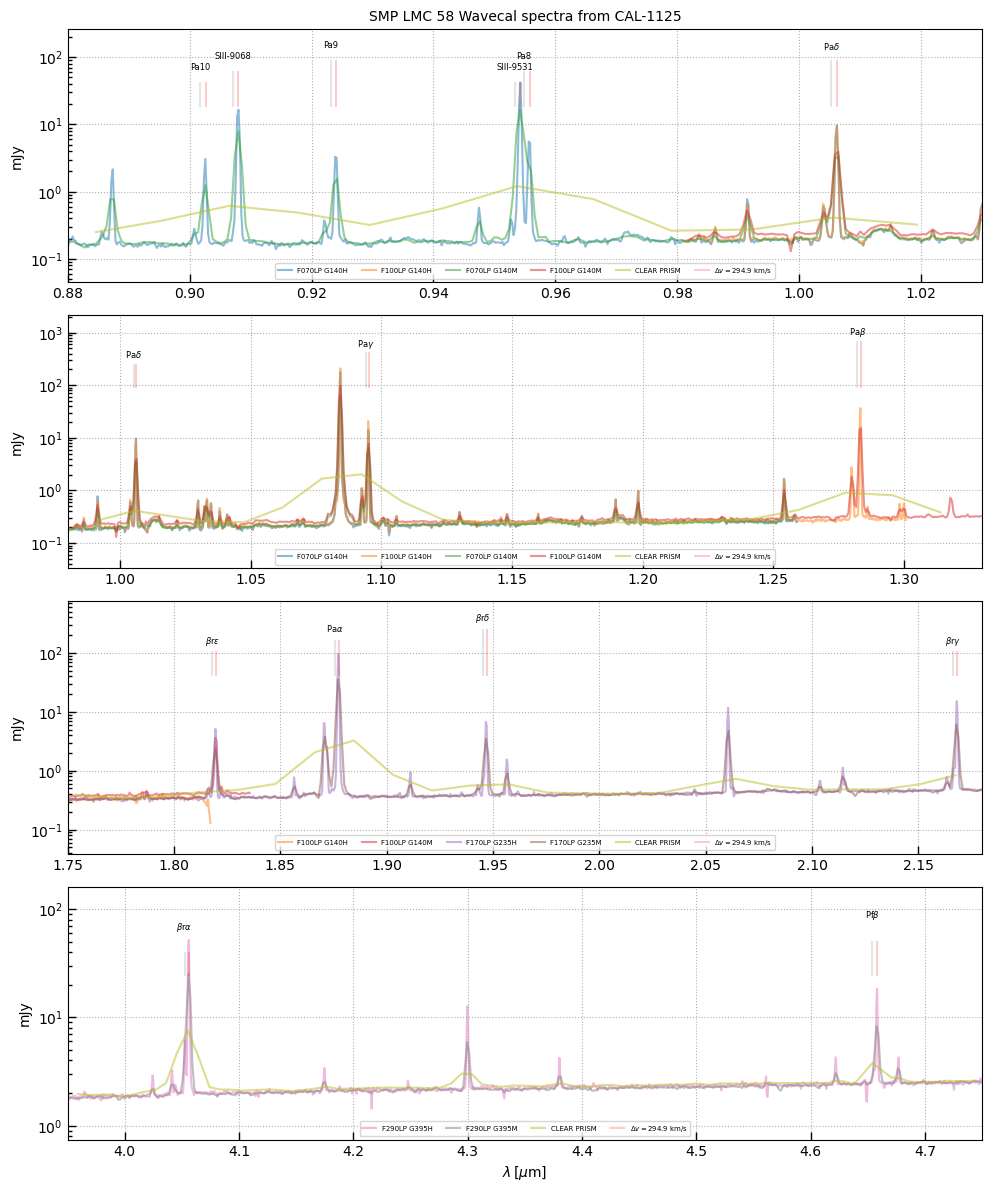

In [7]:
lw, lr = utils.get_line_wavelengths()

lims = [(0.88, 1.03), (0.98,1.33), (1.75, 2.18), (3.95, 4.75)]

fig, axes = plt.subplots(len(lims),1,figsize=(10,3*len(lims)))

for ix, xlim in enumerate(lims):
    ax = axes[ix]
    
    for k in spec:
        masked_mjy = spec[k]['flux_mjy']*1
        masked_mjy[(spec[k]['wave'] < xlim[0]) | (spec[k]['wave'] > xlim[1])] = np.nan
        if np.isfinite(masked_mjy).sum() > 0:
            ax.plot(spec[k]['wave'], masked_mjy, label=k, alpha=0.5, color=COLORS[k])

    ax.set_xlim(xlim)

    # Line labels
    lgreek = lambda ln : ln.replace('A',r'$\alpha$').replace('B',r'$\beta$').replace('G',r'$\gamma$').replace('D',r'$\delta$').replace('E',r'$\epsilon$')

    lws, lns = [], []
    for l in lw:
        #if (l[:2] in ['Pa','Br','Pf']) | ('1083' in l):
        if (lw[l][0]/1.e4 > xlim[0]) & (lw[l][0]/1.e4 < xlim[1]) & (len(lw[l]) == 1):
            lws.append(lw[l][0]/1.e4)
            lns.append(l)

    jwrap = 3
    ax.semilogy()
    yr = np.array(ax.get_ylim())
    
    logr = np.diff(np.log10(yr))[0]
    wpad = 1.15**(logr)
    yr *= wpad**np.array([-2,4])
    
    ax.set_ylim(yr)
    
    yl = yr[1] / wpad**jwrap
    
    for j, i in enumerate(np.argsort(lws)):
        ax.text(lws[i], yl*wpad**(j % jwrap), lgreek(lns[i]), ha='center', va='top', fontsize=6)
        ax.plot(np.ones(2)*lws[i],
                [yl*0.5*wpad**-2, yl*0.5*wpad**(j % jwrap)],
                color='k', linestyle='-', alpha=0.1)
        
        # Show corrected
        ax.plot(np.ones(2)*lws[i]*(1+dv/2.99e5), 
                [yl*0.5*wpad**-2, yl*0.5*wpad**(j % jwrap)],
                color='r', linestyle='-', alpha=0.2,
                label=(r'$\Delta v = $' + f'{dv:.1f} km/s' if j == 0 else None),
               )

    ax.set_ylabel(r'mJy')
    ax.legend(loc='lower center', ncol=10, fontsize=5)
    ax.grid()
    
axes[0].set_title('SMP LMC 58 Wavecal spectra from CAL-1125')

ax.set_xlabel(r'$\lambda\,[\mu\mathrm{m}]$')

fig.tight_layout(pad=1)
fig.tight_layout(pad=1)

fig.savefig(f'smp58_nirspec_dv.png', dpi=FIGURE_DPI)